In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pylab as plt
from zeta.train import ZetaTrainSQL


# Data

In [6]:
train_sql = ZetaTrainSQL()
data_df = train_sql.get_ohlcv('000660')
data_df.tail()

,stock_id,stock_code,Open,High,Low,Close,Volume,PriceVolume,adjusted_type,adjusted_ratio
date,,,,,,,,,,
2021-08-30,1377,000660,105000.0,105500.0,103500.0,103500.0,1815760.0,188840.0,0.0,0.0
2021-08-31,1377,000660,103500.0,106500.0,102000.0,106500.0,4979280.0,520812.0,0.0,0.0
2021-09-01,1377,000660,106000.0,108000.0,104500.0,108000.0,4736180.0,504302.0,0.0,0.0
2021-09-02,1377,000660,108000.0,108500.0,106000.0,106500.0,2724560.0,291367.0,0.0,0.0
2021-09-03,1377,000660,106500.0,107500.0,106000.0,107000.0,2493050.0,266006.0,0.0,0.0


# Labeling

ML에서 레이블링은 매우 중요합니다. <br>
예를 들어, image classification labeling에서 강아지를 고양이라고 하거나, 고양이를 사자라고 한다면 학습은 잘 안될 겁니다. <br>
마찬가지로 파이낸셜을 ML로 돌리기 위해서는 적절한 레이블링을 적용해주는 것이 매우 중요합니다. 

## Fixed-Time Horizon Method 

대부분의 시계열 방법론에서 h 이후의 고정된 시간에서 지표가 올랐는지 떨어졌는지로 레이블링을 합니다. <br>
하지만 단연컨데.. 이 방법은 주가 레이블링에서는 가장 멍청한 방법중 하나입니다. <br>

1. 샘플링 이슈가 있습니다. 
    - 장초반, 장 끝나기전 10분이 가장 변동성도 크며, 주문량도 큽니다. 
    - 반면에 오후 12시쯤부터는 다들 밥먹으러 가고, 쉬기 때문에 체결량은 현저하게 떨어집니다. 
    - 따라서.. 고정적인 시간단위로 샘플링을 하게 된다면 장초반, 끝나기전 10분은 under sampling이 되며, 오후 시간대는 over sampling이 됩니다. 
2. 통계적 유의미성이 없습니다. 
    - 시계열간의 상관관계나, 정규성이 있어야 하는데. 주가는 그런 통계적 유의미성이 없습니다. 
    - 참고로.. 이런 문제를 해결하기 위해서 Volume Bar, Dollar Bar같은 방법론들이 등장했습니다.
3. 변동성에 취약합니다. 
    - 아래 공식에서 써놨듯이 특정 델타값 이상 또는 이하일 경우를 찾는데.. 종목마다 모두 다른 변동성을 갖고 있으며, 이벤트가 있을때마다 모두 다릅니다.
    - 따라서 고정된 델타값 또한 문제가 있습니다. 

참고로.. Fixed-Time Horizon Method의 공식은 다음과 같이 적용할 수 있습니다.

$$ \begin{align} r &= \frac{p_t + p_{t+h}}{p_t} - 1  \\
y_i &= 
\begin{cases}
-1 & \text{if } r < - \delta \\
0 &  \text{if } | r | \le \delta \\
1 &  \text{if } r > \delta
\end{cases}
\end{align} $$

p는 가격이고, 그냥 percentage로 변환한 다음 어떤 특정 델타값 이상, 이하면 증감으로 레이블링을 한다는 것 입니다. 


## Volatility Threshold

Fixed-time horizon method의 문제중 하나는 변동성을 포함하고 있지 않는다는 것 입니다.<br>
이부분이 중요한 이유는 실제 알고리즘 트레이딩에서는 profit taking 그리고 stop loss를 반드시 설정하기 때문입니다. <br>
아래는 하나의 예 일 뿐입니다. 

변동성을 확인하기 위해서.. 전날 종가와 비교해서 exponential weighted standard deviation을 구하기도 합니다. <br>
또는 여기서 더 나아가 다음날 종가를 머신러닝 모델을 태워서 예측 하기도 합니다. <br>
어려운 내용이 아니기 때문에 개념만 설명하고 넘어갑니다. 

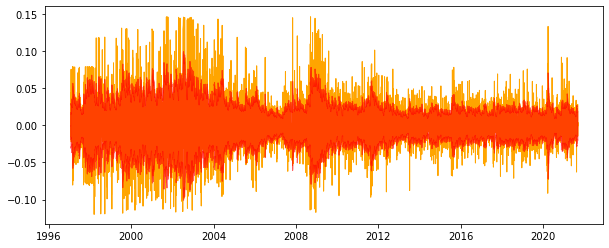

In [27]:
pct_change = data_df.Close/ data_df.Close.shift() - 1 # np.minimum(data_df.Low, data_df.Close.shift()) - 1
pct_change = pct_change[(pct_change.quantile(0.01) < pct_change) & 
                        (pct_change < pct_change.quantile(0.99))]

volatility = pct_change.ewm(7).std().iloc[7:]
pct_change = pct_change.iloc[7:]

fig, ax = plt.subplots(1, figsize=(10, 4))
ax.fill_between(pct_change.index, 0, pct_change, color='orange')
ax.fill_between(volatility.index, -volatility, volatility, color='red', alpha=0.6)

## Triple-Barrier Method

Volatility threshold 방법은 변동성에 따라서 상승, 하락 (또는 profit taking, stop loss) 를 다이나믹하게 잡아주는데 좋은 방법입니다.<br>
문제는 .. 얼마나 오랫동안 들고 있어야 하는지 입니다. <br>
무한정 기다려서 upper bound 또는 under bound를 주가가 넘어갈때를 기다릴수는 없습니다. 

이 문제를 해결하기 위해서, 하나의 barrier를 더해 줍니다. 

| Name             | Label   | Description                                                      |
|:-----------------|:--------|:-----------------------------------------------------------------|
| Upper Barrier    | 1       | 윗쪽 barrier에 주가가 처음 닿을때                                     |  
| Vertical Barrier | 0       | 일정 시점이후까지도 upper 또는 under barrier에 닿지 않고 주가가 횡보할 경우 | 
| Under Barrier    | -1      | 아래쪽 barrier에 주가가 처음 닿을때                                    |

위의 내용은 일종의 기본형이고, 응용버젼은 매우 많습니다.<br>
더 간단하게 만들기 위해서 Vertical Barrier 는 학습에서 제외시키고, binary classification으로 만든다던가.. <br>
또는 메타 데이터 또는 메타 레이블을 넣어서 좀 더 복잡하게도 만들수 있습니다. <br>
중요한건.. 기본형은 이렇다라는 것 입니다 .

## Meta Labeling 

Triple-barrier 기반으로 만들어진 모델을 primary model 이라고 하겠습니다. <br>
primary model의 문제점은 기술적으로 다음과 같습니다. 

 - 얼마만큼의 베팅을 해야 하는가? -> 모름
 - binary classification의 문제 -> high true positive rate(Recall) 증가하면 false positive 또한 증가. 또는 그 반대

메타 레이블링은.. primary model이 상승한다고 예측한 데이터만 골라서, <br>
다시 tripple-barrier label을 통한 second model을 생성 -> 이 경우 TP 와 FP안에서 accuracy를 높입니다. <br>
이때 tripple-barrier가 primary model과 동일할 필요는 없으며, 또는 input에 들어가는 데이터를 다르게 해주기도 합니다. 


베팅 사이즈는 second model에서 나온 확률값으로, 해당 확률만큼 베팅 사이즈를 설정 합니다. <br>
실전에서는 primary model은 성능을 높이기 위해서 작은 모델로, 그리고 second 모델은 좀 더 복잡한 모델을 사용 합니다. 